# Hacking together PDBBind database for proof-of-principle

This work is going LIGHTENING FAST!

This code is to quickly hack the PDBBind core dataset into an icosahedron form. We're using only the binding sites. The core set contains only about 150 proteins. 

Here goes!


(This is based on the hacky proof of principle data used in the RSC AIChem conference in Sept 2020)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
import operator
import functools
import os
import gif
import h5py
import scipy.linalg
import slugify

from skspatial.objects import Point, Vector, Triangle
from operator import attrgetter
from scipy.constants import golden
from IPython.display import HTML

In [2]:
# Constants
_unit_length = np.sqrt(1+(golden*golden))
# the two distances we need for the coordinates.
_c1 = 1 / _unit_length
_c2 = golden / _unit_length
# The points that make up an icosahedron in space, circumradius 1, centered around 0,0,0
_points = [
        Point([-_c1,  _c2,   0]),
        Point([ _c1,  _c2,   0]),
        Point([ _c1, -_c2,   0]),
        Point([-_c1, -_c2,   0]),
        Point([-_c2,   0, -_c1]),
        Point([ _c2,   0, -_c1]),
        Point([ _c2,   0,  _c1]),
        Point([-_c2,   0,  _c1]),
        Point([  0,  _c1, -_c2]),
        Point([  0,  _c1,  _c2]),
        Point([  0, -_c1,  _c2]),
        Point([  0, -_c1, -_c2])
        ]

_edges = [
    frozenset([0, 1]),
    frozenset([8, 1]),
    frozenset([5, 1]),                 
    frozenset([6, 1]),
    frozenset([9, 1]),                 
    frozenset([0, 8]),
    frozenset([8, 5]),                 
    frozenset([5, 6]),
    frozenset([6, 9]),                 
    frozenset([9, 0]),                 
    frozenset([0, 4]),
    frozenset([4, 8]),
    frozenset([8, 11]),                 
    frozenset([11, 5]),
    frozenset([5, 2]),                 
    frozenset([2, 6]),
    frozenset([6, 10]),                 
    frozenset([10, 9]),
    frozenset([9, 7]),                 
    frozenset([7, 0]),   
    frozenset([4, 11]),
    frozenset([11, 2]),
    frozenset([2, 10]),                 
    frozenset([10, 7]),
    frozenset([7, 4]),                 
    frozenset([4, 3]),
    frozenset([11, 3]),                 
    frozenset([2, 3]),
    frozenset([10, 3]),                 
    frozenset([7, 3]) 
]

# Used to make sure the ico will fit in a 3D render
_scale = np.array(_points).flatten('K')

# How high to draw triangles for 2D output
_triangle_2d_hypotenuse = 6
_triangle_2d_height = np.sqrt( _triangle_2d_hypotenuse**2 - (_triangle_2d_hypotenuse/2)**2)

In [3]:
class Molecule(object):
    """ Holds a molecule
    """
    
    # Load the standard colours and convert into the right format for matplotlib.
    _colour_frame = pd.read_csv(os.path.join("JMolColors-master","JMolColors-master","jmolcolors.csv"))
    _colour_list = {}
    for _,a in _colour_frame.iterrows():
        _colour_list[a['atom']] = (a['R'] / 255.0, a['G'] / 255.0, a['B'] / 255.0)
    # for reasons, override carbon and hydrogen
    _colour_list['C'] = (0.0, 0.0, 0.0)
    _colour_list['H'] = (0.0, 0.5, 0.5)
    
    @classmethod
    def get_atom_colour(cls, atom):
        """ Returns RGB color tuple corresponding to atom
        :param str atom: symbol for atom
        """
        return cls._colour_list[atom]
    
    @classmethod
    def get_atom_colour_list(cls, atom_list):
        """ Get a list of the corresponding colours for a list of atoms.
        """
        return [cls.get_atom_colour(a) for a in atom_list]
    
    @staticmethod
    def _atoms_from_mol_file(mol_file,no_of_atoms):
        """Grabs the atoms from a read in version of a molfile
        """
        chopped_mol=mol_file.split('\n')[4:]
        atom_list=[]
        for idx in range(no_of_atoms):
            line=chopped_mol[idx].split(' ')
            data=[x for x in line if not x =='']
            atom_list.append(data[3])
        return atom_list
    
    def _parse_conformer(self):
        self.coords = self.conformer.GetPositions()
        # now scale them to fit the sphere.
        coords_max = max(self.coords.flatten()) / 0.75
        self.coords /= coords_max
        self.coords_x = self.coords[:,0]
        self.coords_y = self.coords[:,1]
        self.coords_z = self.coords[:,2]
    
    def get_atom(self, idx):
        """ Get the RDKit Atom object by index
        """
        return self.molecule.GetAtoms()[idx]
    
    def __init__(self,smiles_string,sanitize=True):
        """ Factory method to build a molecule from a smiles string.
        """
        # Parse the molecule
        base_m = rdkit.Chem.MolFromSmiles(smiles_string,sanitize=sanitize)
        rdkit.Chem.AllChem.EmbedMolecule(base_m)
        # Add the hydrogens
        molecule = rdkit.Chem.AddHs(base_m)
        rdkit.Chem.AllChem.EmbedMolecule(molecule)
        # use MMFF94 to minimise and make a nice structure
        rdkit.Chem.AllChem.MMFFOptimizeMolecule(molecule)
        
        # get a conformer, any conformer and parse it.
        self.conformer = molecule.GetConformers()[0]
        self._parse_conformer()
        
        self.atom_count = self.conformer.GetNumAtoms()
        
        # get molefile
        mol_file=rdkit.Chem.MolToMolBlock(molecule)
        self.atom_list=Molecule._atoms_from_mol_file(mol_file, self.atom_count)
        self.colour_list = Molecule.get_atom_colour_list(self.atom_list)
        
        self.molecule = molecule
        self.smiles = smiles_string
    
    def draw3D(self, target):
        """ Draw the object in 3d
        """
        target.scatter(self.coords_x, self.coords_y, self.coords_z, self.colour_list)
    
    def __repr__(self):
        return repr("Molecule: {}".format(self.smiles))
        

In [4]:
class PDBMolecule(Molecule):
    """ Holds a molecule
    """
    def __init__(self,file_location,sanitize=True):
            """ Factory method to build a molecule from a smiles string.
            file_location is the location of hte file to read in on disk
        """
            molecule=rdkit.Chem.rdmolfiles.MolFromPDBFile(file_location,sanitize=sanitize)
            # get a conformer, any conformer and parse it.
            self.conformer = molecule.GetConformer()
            rdkit.Chem.rdMolTransforms.CanonicalizeConformer(self.conformer)
            self._parse_conformer()

            self.atom_count = self.conformer.GetNumAtoms()
            self.atom_list=[x.GetSymbol() for x in molecule.GetAtoms()]

            self.colour_list = Molecule.get_atom_colour_list(self.atom_list)

            self.molecule = molecule
            self.smiles = ''
     

In [61]:
class Mol2Molecule(Molecule):
    """ Holds a molecule
    """
    def __init__(self,file_location,sanitize=False):
            """ Factory method to build a molecule from a smiles string.
            file_location is the location of hte file to read in on disk
        """
            # Parse the molecule
            #base_m = rdkit.Chem.MolFromSmiles(smiles_string)
            #rdkit.Chem.AllChem.EmbedMolecule(base_m)
            # Add the hydrogens
            #molecule = rdkit.Chem.AddHs(base_m)
            #rdkit.Chem.AllChem.EmbedMolecule(molecule)
            # use MMFF94 to minimise and make a nice structure
            #rdkit.Chem.AllChem.MMFFOptimizeMolecule(molecule)
            molecule=rdkit.Chem.rdmolfiles.MolFromMol2File(
                file_location,  
                cleanupSubstructures=False, 
                sanitize=sanitize)
            # get a conformer, any conformer and parse it.
            self.conformer = molecule.GetConformer()
            rdkit.Chem.rdMolTransforms.CanonicalizeConformer(self.conformer)
            self._parse_conformer()

            atom_count = self.conformer.GetNumAtoms()

            # get molefile
            mol_file=rdkit.Chem.MolToMolBlock(molecule,kekulize=False)
            self.atom_list=Molecule._atoms_from_mol_file(mol_file, atom_count)
            self.colour_list = Molecule.get_atom_colour_list(self.atom_list)

            self.molecule = molecule
            self.smiles = ''

In [6]:
class Face(object):
    """A class to define a face on an icosphere
    a,b,c are the points in 3D space of points on an icosphere
    u,v are the coordinates on a 2D plane corresponding to the unfolded icosphere net
    children are the faces at the next layer of magnification (anti coarse graining of a sphere)
    atoms are the atoms that project onto that face"""
    
    @staticmethod
    def face_get_colour(face):
        """ hook function to look up the individual colour of a face.
        Mostly implemented as a demonstration of how to do the plugin approach to calculation.
        """
        if not face.atoms:
            # Nothing to see here.
            return (1.0, 1.0, 1.0)

        if len(face.atoms) == 1:
            # Only one choice
            return Molecule.get_atom_colour(face.molecule.get_atom(face.atoms[0][1]).GetSymbol())

        atom_list = [face.molecule.get_atom(x).GetSymbol() for _,x in face.atoms]
        atom1 = [ a for a in atom_list if a is not "H"]
        atom2 = [ a for a in atom1 if a is not "C"]

        if atom2:
            # Something more interesting than Carbon / Hydrogen. Pick the first
            return Molecule.get_atom_colour(atom2[0])
        if atom1:
            # Carbon at least
            return Molecule.get_atom_colour("C")
        # must have been multiple hydrogens
        return Molecule.get_atom_colour("H")    
    
    
    @staticmethod
    def face_get_masses(face):
        """ Returns the masses of the atoms associated with this face as a 3-tuple:
            1) mass of the atom closest to the centre of the molecule
            2) mass of the atom furthest to the centre of the molecule
            3) total mass of all atoms associated with this face
        """
        min_distance =  max_distance = None
        min_mass =  max_mass = total_mass = 0.0
        # TODO: this is clunky. FIX IT
        for distance, idx in face.atoms:
            atom_mass = face.molecule.get_atom(idx).GetMass()
            if not min_distance or distance < min_distance:
                min_distance = distance
                min_mass = atom_mass
            if not max_distance or distance > max_distance:
                max_distance = distance
                max_mass = atom_mass
            total_mass += atom_mass
        
        return (min_mass, max_mass, total_mass)
    
    # The function to use when determining the values of a face.
    _lookup_func = face_get_colour
    
        
    def __init__(self, molecule, a=None, b=None, c=None):
        self.molecule = molecule # the molecule we are drawing from.
        self.a = Vector(a) # these are vectors from 0,0,0 to x y z etc
        self.b = Vector(b)
        self.c = Vector(c)
        self.triangle = Triangle(a,b,c)
        self.normal = self.triangle.normal()
        self.u = None
        self.v = None
        self.w = None
        self.midpoint = None
        self.children = []
        self.atoms = [] # list of (distance from centre, atom_index) tuples
        

    def create_children(self, levels_to_do=1):
        """triangles are formed at the midpoints of edges
            we label points in a clockwise manner ALWAYS"""
        if self.children:
            # check we not got no children already
            raise ValueError("create children called on face with children already assigned")
        if levels_to_do == 0:
            return
        # ab is the left hand edge of the triangle
        # finds the mid-point on the line defined by x, y
        # AND PROEJCTS IT TO THE UNIT SPHERE EASY!
        ab = ((self.a + self.b) /2).unit()
        bc = ((self.b + self.c) /2).unit()
        ca = ((self.c + self.a) /2).unit()
        self.children = [ # the four new triangles
            Face(self.molecule, self.a, ab, ca), # 1 bottom left
            Face(self.molecule, ab, self.b, bc), # 2 top
            Face(self.molecule, ca, bc, self.c), # 3 bottom right
            Face(self.molecule, ab, bc, ca)] # 4 middle
        for child in self.children:
            # this should work...
            child.create_children(levels_to_do-1)

    def get_mesh(self):
        """ Return the mesh for this face as an array.
        """
        if self.children:
            return functools.reduce(operator.add, [c.get_mesh() for c in self.children])
        
        # Leaf node
        return [[self.a, self.b, self.c]]
    
    def get_values(self):
        """ Use the class lookup function to determine the values associated with this face.
        e.g. the colours to render with.
        """
        return self._lookup_func()
    
    def _get_colour(self):
        """ hard coded version of _get_values that always uses face_get_colour to determine values.
        """
        return self.face_get_colour(self)
    
    def _map_coords(self, u, v, w):
        """ Inner function for working out the file locations
            uvw need to be specified in clockwise order.
        """
        ux, uy = u
        vx, vy = v
        wx, wy = w
        self.u = u
        self.v = v
        self.w = w
        
        
        self.midpoint_x = (ux + vx + wx) / 3 
        # only going to approximate Y
        self.midpoint_y = (min(uy, vy, wy) + max(uy, vy, wy)) / 2
        
        self.midpoint = self.midpoint_x, self.midpoint_y
        
        if self.children:
            uv = ((ux + vx) / 2, (uy + vy) / 2)
            vw = ((vx + wx) / 2, (vy + wy) / 2)
            wu = ((wx + ux) / 2, (wy + uy) / 2)
            self.children[0]._map_coords(u, uv, wu)
            self.children[1]._map_coords(uv, v, vw)
            self.children[2]._map_coords(wu, vw, w)
            self.children[3]._map_coords(uv, vw, wu)
    
    def _draw(self, plot):
        """ Inner function for the drawing. Plots this face between the points shown.            
        """
        if not self.midpoint:
            raise ValueError("_draw called before _map_coords")
        if not self.children:
            xs = np.array([x for x,_ in [self.u, self.v, self.w]])
            ys = np.array([y for _,y in [self.u, self.v, self.w]])
            tris = np.array([[0,1,2]])
            tri = matplotlib.tri.Triangulation(xs, ys, tris)
        
            x=matplotlib.pyplot.Polygon(np.array([self.u, self.v, self.w]), 
                                        ec='k', 
                                        closed=True, 
                                        color=self._get_colour())
            plot.gca().add_patch(x)
        
            return
        for child in self.children:
            child._draw(plot)        
        
    def add_atom(self, location, idx):
        """ Add a specific atom to the face
        """
        self.atoms.append((scipy.linalg.norm(location), idx))
        if not self.children:
            return
        best_child = None
        best_angle = None
        for child in self.children:
            angle = location.angle_between(child.normal)
            if best_child is None or angle < best_angle:
                best_child = child
                best_angle = angle
        best_child.add_atom(location, idx)

    def get_leaf_faces(self):
        """ Returns a list of the lowest level faces
        """
        if self.children:
            if self.children[0].children:
                # recursive case
                result = []
                for child in self.children:
                    result += child.get_leaf_faces()
                return result
            else:
                # this is the parent of a set of leaves
                return self.children
        else:
            raise ValueError("get_leaf_faces reached actual leaf face. Shouldn't happen.")
    
    def __repr__(self):
        """ Print the Face."""
        #output = "Face: {}".format(self.triangle)
        output = "Face"
        
        if self.midpoint:
            output += " at {}".format(self.midpoint)
            
       # if self.u:
        #    output += " ({},{},{})".format(self.u, self.v, self.w)
            
        if self.atoms:
            output += " with {}".format(self.atoms)
        return repr(output)

In [7]:
class TopFace(Face):
    """ A Face that exists at the top level of the icosahedron.
        Contains extra functions  that inner faces do not need.
    """
    def __init__(self, molecule, a_idx, b_idx, c_idx):
        super().__init__(molecule, _points[a_idx],_points[b_idx],_points[c_idx])
        self.edges = {
            (a_idx,b_idx),
            (b_idx,c_idx),
            (c_idx,a_idx)
        }
        self.indices = [a_idx, b_idx, c_idx]
        self.neighbours = []
        # Where in the 2D unwrapped grid to render this face
        self.grid_coords = None                        
        
    def get_edges(self):
        """ Returns a set of the edges that this face has.
        """
        return [frozenset(x) for x in self.edges]
    
    def get_point_indices(self):
        """ Returns a set of the point indices that this face has.
        """
        return self.indices
    
    def clear_grid(self):
        """ Clear the grid before a fresh unwrap."""
        self.grid_coords = None                

    def _set_grid_first_row(self, top_idx, column):
        """ Recurse along the top row of the grid, initialising them
        """
        if top_idx not in self.indices:
            raise ValueError("Invalid point index.")
            
        if self.grid_coords is not None:
            # we've come all the way around. Stop
            return        
        
        self.grid_coords = (0, column)
        # Now find the faces to update.
        # next point is the point adjacent to the top point on the edge shared with the next
        # face on the top row. It is also a point shared with the adjacent face on the second row
        next_point = [b for a,b in self.edges if a==top_idx][0]
        next_faces = [n for n in self.neighbours if next_point in n.indices]
        assert(len(next_faces)==2)
        for next_face in next_faces:
            if top_idx in next_face.indices:
                # This is the one at the top of the next column.
                next_face._set_grid_first_row(top_idx,column+1)
                continue
            
            # This is the one below us on the second row  
            assert(next_face.grid_coords is None)
            next_face.grid_coords = (1, column)
            
            # Find the one in the third row.
            third_face_candidates = [f for f in next_face.neighbours if (next_point in f.indices and f is not self)]
            assert(len(third_face_candidates)==1)
            third_face = third_face_candidates[0]
            assert(third_face.grid_coords is None)
            third_face.grid_coords = (2, column)
            
            # finally the fourth row.
            # two ways we could do it:
            # a. It is the neighbour of third_face that shares a point with next_face
            # b. It is the neighbour of third_face that is on the edge that does not contain next_point
            # Going with a.
            point_2_4 = [b for a,b in next_face.edges if a==next_point][0]
            fourth_face_candidates = [f for f in third_face.neighbours if (point_2_4 in f.indices and f is not next_face)]
            if( len(fourth_face_candidates) != 1):
                print("Third face neighbours:\n{}".format(third_face.neighbours))
                print("Second face:\n{}".format(next_face))
                print("Third face:\n{}".format(third_face))
                print("Second_fourth point: {}".format(point_2_4))
                print(fourth_face_candidates)
                
            assert(len(fourth_face_candidates)==1)
            fourth_face = fourth_face_candidates[0]
            assert(fourth_face.grid_coords is None)
            fourth_face.grid_coords = (3, column)                       
        
        
    def set_grid(self, top_idx):
        """ Initialise the grid, with the point marked as top_idx as the top point
            and self as 0,0
        """        
        self._set_grid_first_row(self.indices[top_idx], 0)
    
    def plot2D(self, height=_triangle_2d_height, width=_triangle_2d_hypotenuse):
        """
        Compute the 2D projection of this face
        """
        if self.grid_coords is None:
            raise ValueError("_project2D called with no grid setup")
        y,x = self.grid_coords
        
        # Time to map from grid space to 2d space
        # If we are on an even numbered row, then we are facing up and our coords will be
        #    v
        #   / \
        #  u - w
        # If we are on an odd numbered row, then we are facing down and our coords will be
        #  u - v
        #   \ /
        #    w        
        
        # first u
        ux = (x +(y//2)/2)* width
        uy = (2 - y//2)*height
        
        if y%2 == 0:
            # even row            
            vx, vy = ux + (width/2.0), uy+height
            wx, wy = ux + width, uy
        else:
            # odd row
            vx, vy = ux + width, uy
            wx, wy = ux + (width/2.0), uy-height
        
        self._map_coords( (ux,uy), (vx,vy), (wx,wy) )
    
    def draw2D(self, plot, height=_triangle_2d_height, width=_triangle_2d_hypotenuse):
        """
        Draw this face onto the supplied plot
        """
        if self.grid_coords is None:
            raise ValueError("draw2D called with no grid setup")
        
        
        self._draw(plot)    

    
    def get_ordered_leaf_faces(self):
        """ Returns a list of the lowest level faces, ordered by their locations
                1           1 2 3
               2 3           4 5 
              4 5 6           6
              etc.
        """        
        if not self.midpoint:
            raise ValueError("get_ordered_leaf_faces called without first plotting.")
            
        face_list = self.get_leaf_faces()
        partial_list = sorted(face_list, key=attrgetter('midpoint_x'))
        return sorted(partial_list, key=attrgetter('midpoint_y'), reverse=True)    
            
    
    def __repr2__(self):
        """ Print the Face."""
        output = "Face: {}".format(self.indices)
        
        if self.midpoint:
            output += " at {}".format(self.midpoint)
            
        if self.u:
            output += " ({},{},{})".format(self.u, self.v, self.w)
            
        if self.atoms:
            output += " with {}".format(self.atoms)
        return repr(output)

In [8]:
class Ico(object):
    """A class to define an icsahedron or icosphere.
    """
    
    def _add_molecule(self, molecule):
        """ Add a molecule to the ico, marking each face nearest each atom
        """
        for idx, location in enumerate(molecule.coords):
            self._add_atom(Vector(location), idx)
            
    def __init__(self, molecule, level=0):
        """ Create a new icosphere.
        Level indicates how many subdivisions to make, 0 (default) will give you an icosohedron.
        All icospheres are centred around the origin with a cicumradius of 1
        """
        self.molecule = molecule
        self.faces = [
                # Top row, around point 1
                TopFace(molecule, 0, 1, 8),
                TopFace(molecule, 8, 1, 5),
                TopFace(molecule, 5, 1, 6),
                TopFace(molecule, 6, 1, 9),
                TopFace(molecule, 9, 1, 0),
                # Row 2
                TopFace(molecule, 0, 8, 4),
                TopFace(molecule, 8, 5, 11), 
                TopFace(molecule, 5, 6, 2),
                TopFace(molecule, 6, 9, 10), 
                TopFace(molecule, 9, 0, 7),
                # Row 3
                TopFace(molecule, 4, 8, 11), 
                TopFace(molecule, 11, 5, 2), 
                TopFace(molecule, 2, 6, 10), 
                TopFace(molecule, 10, 9, 7), 
                TopFace(molecule, 7, 0, 4),
                # Bottom row, around point 3
                TopFace(molecule, 4, 11, 3), 
                TopFace(molecule, 11, 2, 3),
                TopFace(molecule, 2, 10, 3), 
                TopFace(molecule, 10, 7, 3),
                TopFace(molecule, 7, 4, 3)
                ]
        
        # Now create a dictionary of which faces have which edge and
        # one of which faces have which point
        self.edge_mappings = {}
        self.point_mappings = {}
        for face in self.faces:
            for edge in face.get_edges():
                try:
                    self.edge_mappings[edge].append(face)
                except KeyError:
                    self.edge_mappings[edge] = [face]
            for idx in face.get_point_indices():
                try:
                    self.point_mappings[idx].append(face)
                except KeyError:
                    self.point_mappings[idx] = [face]
        
        
        # Use this to tell each face what its neighbours are
        for idx in self.edge_mappings:
            if len(self.edge_mappings[idx]) != 2:
                print("{}:{}".format(idx, self.edge_mappings[idx]))
            assert(len(self.edge_mappings[idx])==2)
            l,r = self.edge_mappings[idx]
            l.neighbours.append(r)
            r.neighbours.append(l)
            

        # now perform the subdivisions
        # conditional isn't needed, but why waste the time?
        if level==0:
            return

        for face in self.faces:
            face.create_children(level)
            
        self._add_molecule(self.molecule)
    
    def get_mesh(self):
        """ return the mesh for this object
        """
        return functools.reduce(operator.add, [f.get_mesh() for f in self.faces])
    
    def _draw_init(self):
        self._figure = matplotlib.pyplot.figure()
        self._axes = mpl_toolkits.mplot3d.Axes3D(self._figure)
        #self._mesh = i3.get_mesh()
        self._mesh = self.get_mesh()

    def _draw_3d(self, a, b):
        """Draw a single 3d frame
            a,b : angles to rotate the view by
        """
        # Load the stuff
        self._axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(self._mesh))
        self._axes.scatter(self.molecule.coords[:,0],self.molecule.coords[:,1],self.molecule.coords[:,2],c=self.molecule.colour_list)
        self._axes.auto_scale_xyz(_scale, _scale, _scale*1.25)
        self._axes.view_init(a,b)         
        # axes.scatter(coords[:,0],coords[:,1],coords[:,2],c=colours)
        matplotlib.pyplot.draw()
    
    def draw3D(self, a=15, b=30):
        """Quick function to draw a single frame
        """
        self._draw_init()
        self._draw_3d(a,b)
        
    def plot2D(self, first_face=0, point_idx=0):
        """Unwrap the icosphere, starting with the specified face, with the indicated point on the top
        """
        # Make sure the request makes sense.
        if first_face < 0 or first_face >= 20 or point_idx < 0 or point_idx >= 3:
            raise ValueError("Face needs to be in range 0..20, point 0..2")
        # clear any grid from previous runs        
        for f in self.faces:
            f.clear_grid()
        
        self.faces[first_face].set_grid(point_idx)
        
        # Now recalculate the grid
        for face in self.faces:
            face.plot2D()
        
        
    def draw2D(self, first_face=0, point_idx=0):
        """Unwrap the ico and draw it, 
        starting with the specified face, with the demarked point up
        """
        # do the plotting
        self.plot2D(first_face, point_idx)
        
        # set up the image
        figure = matplotlib.pyplot.figure()
        matplotlib.pyplot.axis('equal')
        #matplotlib.pyplot.axis('off')
        
        for f in self.faces:
            f.draw2D(figure)
        matplotlib.pyplot.autoscale(enable=True, axis='both')

        matplotlib.pyplot.draw()
    
    def _add_atom(self, location, idx):
        best_face = None
        best_angle = None
        for face in self.faces:
            angle = location.angle_between(face.normal)
            if best_face is None or angle < best_angle:
                best_face = face
                best_angle = angle
        best_face.add_atom(location, idx)

    
    def get_face_list(self):
        """ Returns a list of the leaf faces in the Icosphere
        """
        result = []
        partial_list = sorted(self.faces, key=attrgetter('midpoint_x'))
        ordered_faces = sorted(partial_list, key=attrgetter('midpoint_y'), reverse=True)    
                
        for face in ordered_faces:
            result += face.get_ordered_leaf_faces()
        return result

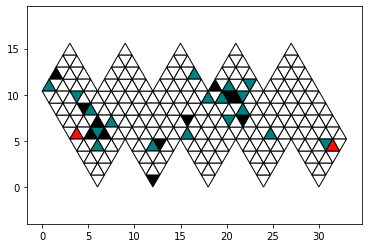

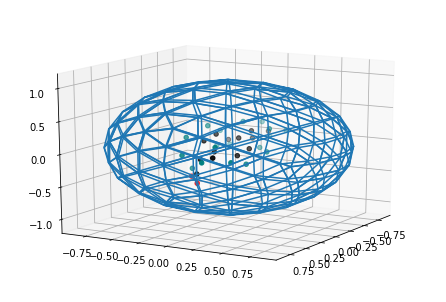

In [9]:
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
i = Ico(m,2)
i.draw2D()
i.draw3D()

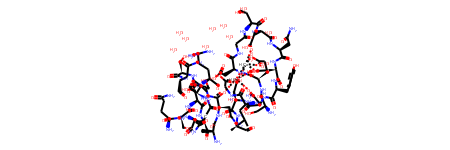

In [10]:
save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
data_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015'
test_file='2jdu_pocket.pdb'
test_file_location=os.path.join(data_dir, '2jdu', test_file)
mol_orig=rdkit.Chem.rdmolfiles.MolFromPDBFile(test_file_location)
mol_orig

In [11]:
egg=mol_orig.GetConformer()

In [12]:
rdkit.Chem.rdMolTransforms.CanonicalizeConformer(egg)

In [13]:
mol=PDBMolecule(test_file_location)

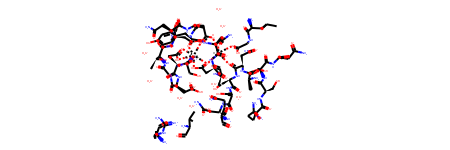

In [14]:
mol.molecule

In [15]:
mol.coords

array([[ 0.35887196, -0.05005412, -0.26680223],
       [ 0.31292442, -0.06735614, -0.20401122],
       [ 0.3232102 , -0.01671002, -0.14201487],
       [ 0.38333272,  0.00412227, -0.12579043],
       [ 0.32869089, -0.14631787, -0.17759856],
       [ 0.26338491,  0.00187626, -0.10741506],
       [ 0.26438198,  0.04784617, -0.04353116],
       [ 0.20474302,  0.02398648,  0.00787061],
       [ 0.14963258,  0.06124091,  0.01444946],
       [ 0.25344526,  0.12739507, -0.06126197],
       [ 0.31768766,  0.15828097, -0.09921744],
       [ 0.37126346,  0.17584842, -0.06567157],
       [ 0.31195108,  0.16537395, -0.17093679],
       [ 0.21335712, -0.03948137,  0.04047901],
       [ 0.15518705, -0.06870773,  0.08562735],
       [ 0.1873076 , -0.12610348,  0.13457675],
       [ 0.23976881, -0.16150501,  0.11556599],
       [ 0.09579951, -0.10223237,  0.03975815],
       [ 0.04428781, -0.13752735,  0.08458473],
       [ 0.15620044, -0.1341995 ,  0.1985464 ],
       [ 0.17686464, -0.19409736,  0.244

In [16]:
molecule=rdkit.Chem.rdmolfiles.MolFromPDBFile(test_file_location)
conformer = molecule.GetConformer()

mol.coords.flatten()

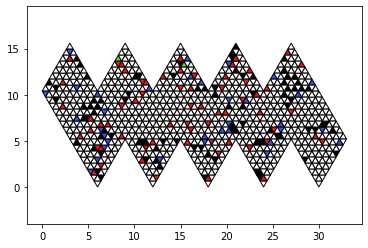

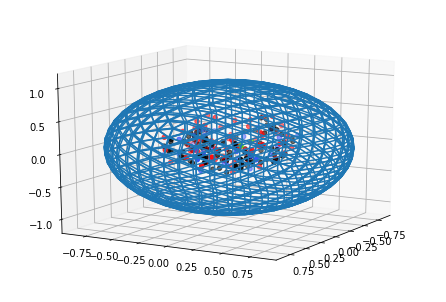

In [17]:
m=mol
ico = Ico(m,3)
ico.draw2D()
ico.draw3D()

In [18]:
test_file='2jdu_ligand.mol2'
test_file_location=os.path.join(data_dir, '2jdu', test_file)
lig=Mol2Molecule(test_file_location)
lig

'Molecule: '

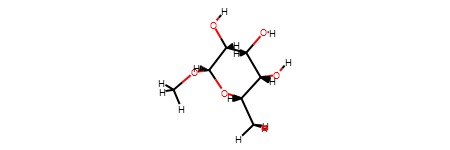

In [19]:
lig.molecule

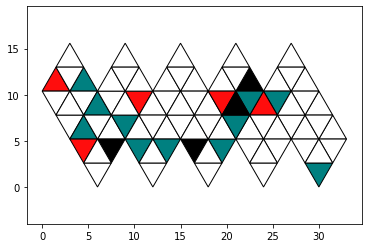

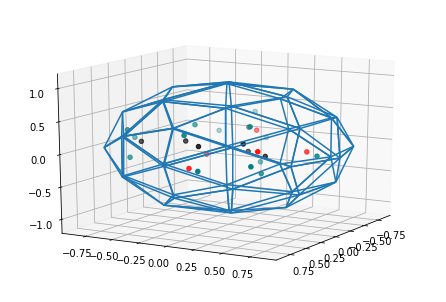

In [20]:
m=lig
ico = Ico(m,1)
ico.draw2D()
ico.draw3D()

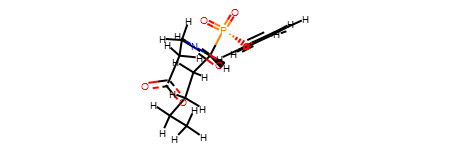

In [21]:
save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015',
data_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015'
test_file='1a0q_ligand.mol2'
test_file_location=os.path.join(data_dir, '1a0q', test_file)
lig=rdkit.Chem.rdmolfiles.MolFromMol2File(test_file_location,  
                                          cleanupSubstructures=False, 
                                          sanitize=False )
lig
#for mol in suppl:
#    print mol.GetNumAtoms()

In [22]:
test_file_location

'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015\\1a0q\\1a0q_ligand.mol2'

In [23]:
def rot_ar_x(radi):
    return  np.array([[1, 0, 0, 0],
                      [0, np.cos(radi), -np.sin(radi), 0],
                      [0, np.sin(radi), np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi), 0],
                      [0, 1, 0, 0],
                      [-np.sin(radi), 0, np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0, 0],
                      [np.sin(radi), np.cos(radi), 0, 0],
                      [0, 0, 1, 0],
                     [0, 0, 0, 1]], dtype=np.double)
tforms = {0: rot_ar_x, 1: rot_ar_y, 2: rot_ar_z}

scale = np.array(_points).flatten('K')
figure = matplotlib.pyplot.figure()
axes = mpl_toolkits.mplot3d.Axes3D(figure)
mesh = i.get_mesh()

def draw(a,b):
    # Load the stuff
    m.draw3D(axes)
    axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(mesh))
    axes.auto_scale_xyz(scale, scale, scale*1.25)
    axes.view_init(a,b) 
    matplotlib.pyplot.draw()

#m.draw3D(axes)
#draw(12,15)
    
def frame(i):
    draw(20,i)
from matplotlib import animation, rc
video=animation.FuncAnimation(figure, frame,frames=360, interval=20).to_html5_video()
HTML(video)

## making a dataset

In [24]:
data_dir

'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'

In [25]:
## This reads in the pdb codes for each protein
fh = open(os.path.join(data_dir, "INDEX_core_name.2013"),'r')
c = 0
column_list_name=["PDB_code", "release_year", "EC_number", "protein_name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[3:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_index_core = pd.DataFrame(lines, columns=column_list_name)

In [26]:
## This reads in the pdb codes for each protein
fh = open(os.path.join(data_dir, "INDEX_refined_name.2015"),'r')
c = 0
column_list_name=["PDB_code", "release_year", "EC_number", "protein_name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[3:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_index_refined = pd.DataFrame(lines, columns=column_list_name)

In [27]:
df_index_refined.head()

,PDB_code,release_year,EC_number,protein_name
0,1i1e,2001,E.C.3.4.24.69,BOTULINUM_NEUROTOXIN_TYPE_B
1,1bxr,1999,E.C.6.3.5.5,CARBAMOYL-PHOSPHATE_SYNTHASE
2,3i3b,2010,E.C.3.2.1.23,BETA-GALACTOSIDASE
3,3dyo,2008,E.C.3.2.1.23,BETA-GALACTOSIDASE
4,3t0d,2012,E.C.3.2.1.23,BETA-GALACTOSIDASE


In [28]:
## This reads in the data for each protein
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_core_data.2013"),'r')
c = 0
column_list_data=["PDB_code", 
             "resolution", 
             "release_year", 
             "-logKd/Ki", 
             "Kd/Ki", 
             "reference",
             "ligand name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            # Not actually the last word!
            last_word = words[5:-1]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
    
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word, words[-1][1:-2]]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_data_core = pd.DataFrame(lines, columns=column_list_data)
df_data_core.head()

,PDB_code,resolution,release_year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3ao4,1.95,2011,2.07,Kd=8.5mM,//_3ao1.pdf,833
1,3i3b,2.20,2010,2.23,Ki=5.9mM,//_3i3b.pdf,149
2,1uto,1.15,2004,2.27,Kd=5.32mM,//_1uto.pdf,PEA
3,1ps3,1.80,2003,2.28,Ki=5.2mM,//_1ps3.pdf,KIF
4,1qi0,2.10,2000,2.35,Ki=4.5mM,//_1qi0.pdf,CBI


In [29]:
## This reads in the data for each protein
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_refined_data.2015"),'r')
c = 0
column_list_data=["PDB_code", 
             "resolution", 
             "release_year", 
             "-logKd/Ki", 
             "Kd/Ki", 
             "reference",
             "ligand name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            # Not actually the last word!
            last_word = words[5:-1]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
    
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word, words[-1][1:-2]]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_data_refined = pd.DataFrame(lines, columns=column_list_data)
df_data_refined.head()

,PDB_code,resolution,release_year,-logKd/Ki,Kd/Ki,reference,ligand name
0,2r58,2.00,2007,2.00,Kd=10mM,//_2r58.pdf,MLY
1,3c2f,2.35,2008,2.00,Kd=10.1mM,//_3c2f.pdf,PRP
2,3g2y,1.31,2009,2.00,Ki=10mM,//_3g2y.pdf,GF4
3,3pce,2.06,1998,2.00,Ki=10mM,//_3pce.pdf,3HP
4,4qsu,1.90,2014,2.00,Kd=10mM,//_4qsu.pdf,TDR


In [30]:

def Create_PDBBind_Dataset(df_cluster, 
                   df_index, 
                   df_data, 
                   DIVISION, 
                   save_dir, 
                   data_dir, 
                   out_filename, 
                   ico_key_name,
                   PDB_or_mol2,
                   do_Hdonors,
                   input_file_end_name='pocket',
                   num_of_proteins_override=0,
                   NUM_MAPS_PER_MOLECULE=60,
                   sanitize=False,
                   SMILES_array=[],
                   verbose=False):
    """ Creates the dataset as a hdf5 file, expects DeepChem PDBBind organised files
    df_cluster = df_cluster_core = df of the cluster data (see the files that DeepChem downloads)
    df_index = df_index_core = df of index data
    df_data = df_data_core = df of the data 
    NUM_MAPS_PER_MOLECULE # how many maps to create
    DIVISION =4 # for the size of icospehre  
    save_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\converted_pdbbind\\v2015'
    data_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'
    out_filename = "PDBBindLigands_core_augmented_withHs_withHdonors_div4.hdf5"
    ico_key_name_name = "icosahedron_level4"
    PDB_or_mol2 : 'pdb', 'mol2'
        :whether files are pdb or mol2 obviously
    input_file_end_name: 'ligand', 'protein', 'pocket'
        :whether files are binding pocket only or whole protein or ligand
    num_of_proteins_override : whether to do only a subset of the list
        : set to 0 to do the entire dataset, else set to how many you want
        : these are just the first ones, not shuffled
    do_Hdonors = True/False, whether to do the H donor data or not, don't do it for proteins
    sanitize = False: wehther to let DeepChem sanitize your molecule (NOT RECOMMENDED!)
    SMILES_array: array of smiles strings if you have them: notcurrently tested
    """
    
    outfile = h5py.File(os.path.join(save_dir,out_filename),"w")
    icosahedron_name = ico_key_name
    
    if num_of_proteins_override == 0:
        # do all proteins woo
        Num_of_proteins= len(df_index_core['PDB_code'])
    else:
        Num_of_proteins = num_of_proteins_override
        
    smile_count = Num_of_proteins
    pdb_list=df_index_core['PDB_code']
    
    string_type = h5py.string_dtype(encoding='utf-8')

    if DIVISION == 1:
        NUM_FACES = 80
    elif DIVISION == 2:
        NUM_FACES = 320
    elif DIVISION == 3:
        NUM_FACES = 1280
    elif DIVISION == 4:
        NUM_FACES = 5120
        
    if NUM_MAPS_PER_MOLECULE == 1:
        NUM_UNWRAPPINGS_TO_DO = 1
        NUM_DIRECTIONS_TO_DO = 1
    elif NUM_MAPS_PER_MOLECULE == 60:
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
    else:
        # TODO implement this if you're going to use it!
        # or set the numbers by hand
        print('Error: Unimplemented! Can only do 1 or 60 maps per molecule!')
        pass    
    
    if sanitize:
        print('Warning! Sanitize seems to muck up the structures, especially for protiens')
        print('Think very carefully about if you want to do this, maybe do some testing in deepchem?')
        
    smiles_count = len(SMILES_array)

    ## this sets up the output datasets
    icosahedron_ds =  outfile.create_dataset(icosahedron_name, (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3))  
    #charge_ds = outfile.create_dataset("charge", (smile_count*NUM_MAPS_PER_MOLECULE,))
    molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
    if smiles_count > 0:
        smiles_ds = outfile.create_dataset("SMILES_strings", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
    MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    if do_Hdonors:
        num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
        num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
    PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
    spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
    eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    # copied from output of df_maker above sigh
    pdb_code_ds = outfile.create_dataset('PDB_code', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    release_year_ds = outfile.create_dataset('release_year', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    ec_number_ds = outfile.create_dataset('EC_number', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    protein_name_ds = outfile.create_dataset('protein_name', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    logkd_ki_ds = outfile.create_dataset('-logKd_over_Ki', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=np.float32)
    kd_ki_ds = outfile.create_dataset('Kd_over_Ki', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    reference_ds = outfile.create_dataset('reference', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    cluster_id_ds = outfile.create_dataset('cluster ID', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    resolution_ds = outfile.create_dataset('resolution', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=np.float32)
    ligand_ds = outfile.create_dataset('ligand_name', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)

    ## Das Loop
    point_ptr = -1                                               
    for mol_idx in range(Num_of_proteins): 
        if mol_idx % 50 == 0:
            print('Got to Molecule no. ', mol_idx)
        # finds the pdb file and reads in the molecule
        file_location=os.path.join(data_dir, 
                                   pdb_list[mol_idx], 
                                   pdb_list[mol_idx] + '_' + input_file_end_name + '.' + PDB_or_mol2)
        if verbose:
            print(file_location)
        if PDB_or_mol2 == 'pdb':
            # doing da protein
            m=PDBMolecule(file_location,sanitize=sanitize)
            tidy_m = m
        elif PDB_or_mol2 == 'mol2':
            m=Mol2Molecule(file_location,sanitize=sanitize)
            tidy_m = m
            tidy_m.molecule.UpdatePropertyCache() # sigh we had to do this to get H donors!
        elif PDB_or_mol2 == 'smiles':
            m=Molecule(SMILES_array[mol_idx])
            tidy_m = m
        else:
            print('Error: file input must be pdb or mol2!')
            return 0
        # puts the molecule into an icosasphere
        i = Ico(m,DIVISION)
        print(pdb_list[mol_idx])
        if smiles_count > 0:
            smiles_string = SMILES_array[mol_idx]
        for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
            for point_idx in range(NUM_DIRECTIONS_TO_DO): 
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### grab the atom values or colours or whatever
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                #### create the measurables you want to record
                values_as_array = np.array(values)
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)
                #### assign measurabless to columns
                icosahedron_ds[point_ptr] = values_as_array
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                if smiles_count > 0:
                    smiles_ds[point_ptr] = smiles_string
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 

                # get the current PDB code
                current_code=df_index[["PDB_code"]].iloc[[mol_idx]]
                current_code=current_code.iloc[0]['PDB_code']
                # get the rows in the dataframes
                current_index_row=df_index.loc[df_index['PDB_code']==current_code]
                #print(current_code)
                current_data_row=df_data.loc[df_data['PDB_code']==current_code]
                current_cluster_row=df_cluster.loc[df_cluster['PDB_code']==current_code]

                pdb_code = current_index_row.iloc[0]['PDB_code']
                pdb_code_ds[point_ptr] = np.array(pdb_code,dtype=string_type)
                release_year = current_index_row.iloc[0]['release_year']
                #print(type(release_year))
                release_year_ds[point_ptr] = release_year
                ec_number = current_index_row.iloc[0]['EC_number']
                ec_number_ds[point_ptr] = ec_number
                protein_name = current_index_row.iloc[0]['protein_name']
                protein_name_ds[point_ptr] = protein_name
                logkd_ki = current_data_row.iloc[0]['-logKd/Ki']
                logkd_ki_ds[point_ptr] = float(logkd_ki)
                kd_ki = current_data_row.iloc[0]['Kd/Ki']
                kd_ki_ds[point_ptr] = kd_ki
                reference = current_data_row.iloc[0]['reference']
                reference_ds[point_ptr] = reference
                cluster_id = current_cluster_row.iloc[0]['cluster ID']
                cluster_id_ds[point_ptr] = cluster_id
                resolution = current_data_row.iloc[0]['resolution']
                resolution_ds[point_ptr] = float(resolution)
                ligand_name = current_data_row.iloc[0]['ligand name']
                ligand_ds[point_ptr] = ligand_name

    outfile.close()   
    i.draw2D()
    return
            


In [31]:
def Create_Dataset_From_SMILES(DIVISION, 
                   save_dir, 
                   data_dir, 
                   out_filename, 
                   do_Hdonors,
                   ico_key_name,
                   num_of_molecules_override=0,
                   NUM_MAPS_PER_MOLECULE=60,
                   sanitize=False,
                   SMILES_array=[],
                   verbose=False):
    """ Creates the dataset as a hdf5 file, expects DeepChem PDBBind organised files
    df_cluster = df_cluster_core = df of the cluster data (see the files that DeepChem downloads)
    df_index = df_index_core = df of index data
    df_data = df_data_core = df of the data 
    NUM_MAPS_PER_MOLECULE # how many maps to create
    DIVISION =4 # for the size of icospehre  
    save_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\converted_pdbbind\\v2015'
    data_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'
    out_filename = "PDBBindLigands_core_augmented_withHs_withHdonors_div4.hdf5"
    ico_key_name_name = "icosahedron_level4"
    PDB_or_mol2 : 'pdb', 'mol2'
        :whether files are pdb or mol2 obviously
    input_file_end_name: 'ligand', 'protein', 'pocket'
        :whether files are binding pocket only or whole protein or ligand
    num_of_proteins_override : whether to do only a subset of the list
        : set to 0 to do the entire dataset, else set to how many you want
        : these are just the first ones, not shuffled
    do_Hdonors = True/False, whether to do the H donor data or not, don't do it for proteins
    sanitize = False: wehther to let DeepChem sanitize your molecule (NOT RECOMMENDED!)
    SMILES_array: array of smiles strings if you have them: notcurrently tested
    """
    
    outfile = h5py.File(os.path.join(save_dir,out_filename),"w")
    icosahedron_name = ico_key_name
    
    if num_of_molecules_override == 0:
        # do all proteins woo
        Num_of_molecules= len(SMILES_array)
    else:
        Num_of_molecules = num_of_molecules_override
        
    smiles_count = Num_of_molecules
    smile_count = Num_of_molecules # yeah i know, is hacky
    
    string_type = h5py.string_dtype(encoding='utf-8')

    if DIVISION == 1:
        NUM_FACES = 80
    elif DIVISION == 2:
        NUM_FACES = 320
    elif DIVISION == 3:
        NUM_FACES = 1280
    elif DIVISION == 4:
        NUM_FACES = 5120
        
    if NUM_MAPS_PER_MOLECULE == 1:
        NUM_UNWRAPPINGS_TO_DO = 1
        NUM_DIRECTIONS_TO_DO = 1
    elif NUM_MAPS_PER_MOLECULE == 60:
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
    else:
        # TODO implement this if you're going to use it!
        # or set the numbers by hand
        print('Error: Unimplemented! Can only do 1 or 60 maps per molecule!')
        pass    
    
    if sanitize:
        print('Warning! Sanitize seems to muck up the structures, especially for protiens')
        print('Think very carefully about if you want to do this, maybe do some testing in deepchem?')
    

    ## this sets up the output datasets
    icosahedron_ds =  outfile.create_dataset(icosahedron_name, (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3))  
    #charge_ds = outfile.create_dataset("charge", (smile_count*NUM_MAPS_PER_MOLECULE,))
    molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
    if smiles_count > 0:
        smiles_ds = outfile.create_dataset('SMILES_strings', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
    MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    if do_Hdonors:
        num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
        num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
    PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
    spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
    eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    # copied from output of df_maker above sigh
    
    ## Das Loop
    point_ptr = -1                                               
    for mol_idx in range(Num_of_molecules): 
        if mol_idx % 50 == 0:
            print('Got to Molecule no. ', mol_idx)
        # finds the pdb file and reads in the molecule
        if verbose:
            print(file_location)

        m=Molecule(SMILES_array[mol_idx],sanitize=sanitize)
        tidy_m = m
        tidy_m.molecule.UpdatePropertyCache() # sigh we had to do this to get H donors!

        # puts the molecule into an icosasphere
        i = Ico(m,DIVISION)
        print(pdb_list[mol_idx])
        if smiles_count > 0:
            smiles_string = SMILES_array[mol_idx]
        for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
            for point_idx in range(NUM_DIRECTIONS_TO_DO): 
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### grab the atom values or colours or whatever
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                #### create the measurables you want to record
                values_as_array = np.array(values)
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)

                #### assign measurabless to columns
                icosahedron_ds[point_ptr] = values_as_array
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                if smiles_count > 0:
                    smiles_ds[point_ptr] = smiles_string
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 


    outfile.close()   
    i.draw2D()
    return
            


In [32]:
## This reads in the cluster for each protein
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_core_cluster.2013"),'r')
c = 0
column_list_cluster=['PDB_code', 
             'resolution', 
             'release_year', 
             '-logKd/Ki', 
             'original_Kd/Ki', 
             'cluster ID']
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[5:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_cluster_core = pd.DataFrame(lines, columns=column_list_cluster)

In [33]:
## This reads in the cluster for each protein
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_refined_set.2015"),'r')
c = 0
column_list_cluster=['PDB_code', 
             'resolution', 
             'release_year', 
             '-logKd/Ki', 
             'original_Kd/Ki', 
             'cluster ID']
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[5:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_cluster_refined = pd.DataFrame(lines, columns=column_list_cluster)

In [34]:
df_cluster_refined.head()

,PDB_code,resolution,release_year,-logKd/Ki,original_Kd/Ki,cluster ID
0,2tpi,2.10,1982,Kd=49uM,//,2tpi.pdf_(2-mer)
1,4tln,2.30,1982,Ki=190uM,//,4tln.pdf_(LNO)
2,1rnt,1.90,1987,Kd=6.5uM,//,1rnt.pdf_(2GP)
3,4ts1,2.50,1989,Kd=11.6uM,//,4ts1.pdf_(TYR)
4,4tmn,1.70,1989,Ki=0.068nM,//,4tmn.pdf_(4-mer)


## This actually builds the dataset!

### Getting colour icosahedron data

In [35]:

Num_of_proteins=len(df_index_refined[["PDB_code"]])
print(Num_of_proteins)
df_cluster_refined.head()

3706


,PDB_code,resolution,release_year,-logKd/Ki,original_Kd/Ki,cluster ID
0,2tpi,2.10,1982,Kd=49uM,//,2tpi.pdf_(2-mer)
1,4tln,2.30,1982,Ki=190uM,//,4tln.pdf_(LNO)
2,1rnt,1.90,1987,Kd=6.5uM,//,1rnt.pdf_(2GP)
3,4ts1,2.50,1989,Kd=11.6uM,//,4ts1.pdf_(TYR)
4,4tmn,1.70,1989,Ki=0.068nM,//,4tmn.pdf_(4-mer)


In [36]:
#### This writes out the commands we need, so we can copy and paste below
## there must be a better way of doing this!
def df_maker(column_list, verbose=True):    
    for header in column_list:
        # this makes the dfs
        cmd = "%s_ds = %s%s%s" % (
                slugify.slugify(header, separator="_"), 
                "outfile.create_dataset('",
                header, 
                "', (smile_count*NUM_MAPS_PER_MOLECULE,))")
        if verbose:
            print(cmd)
    return cmd

def df_writer(column_list,current_row):
    verbose=True
    for header in column_list:
        # this makes the dfs
        cmd1 = "%s = %s%s%s" % (
                slugify.slugify(header, separator="_"), 
                "current_row.iloc[0]['",
                header, 
                "']")
        cmd2 = "%s_ds[point_ptr] = %s" % (
                slugify.slugify(header, separator="_"),
                slugify.slugify(header, separator="_"))

        if verbose:
            print(cmd1)
            print(cmd2)
    return (cmd1, cmd2)
    
df_maker(column_list_name)
df_maker(column_list_data[3:])
df_maker([column_list_cluster[-1]])

for pro in range(1):
    # get the current PDB code
    current_code=df_index_core[["PDB_code"]].iloc[[pro]]
    current_code=current_code.iloc[0]['PDB_code']
    # get the rows in the dataframes
    current_index_row=df_index_core.loc[df_index_core['PDB_code']==current_code]
    #print(current_code)
    current_data_row=df_data_core.loc[df_data_core['PDB_code']==current_code]
    current_cluster_row=df_cluster_core.loc[df_cluster_core['PDB_code']==current_code]
    print(current_index_row)
    #print(current_data_row)
    #print(current_cluster_row)
    #current_row = current_index_row
    #column_list = column_list_name
    df_writer(column_list_name,current_index_row)
    df_writer(column_list_data[3:],current_data_row)
    df_writer([column_list_cluster[-1]],current_cluster_row)



pdb_code_ds = outfile.create_dataset('PDB_code', (smile_count*NUM_MAPS_PER_MOLECULE,))
release_year_ds = outfile.create_dataset('release_year', (smile_count*NUM_MAPS_PER_MOLECULE,))
ec_number_ds = outfile.create_dataset('EC_number', (smile_count*NUM_MAPS_PER_MOLECULE,))
protein_name_ds = outfile.create_dataset('protein_name', (smile_count*NUM_MAPS_PER_MOLECULE,))
logkd_ki_ds = outfile.create_dataset('-logKd/Ki', (smile_count*NUM_MAPS_PER_MOLECULE,))
kd_ki_ds = outfile.create_dataset('Kd/Ki', (smile_count*NUM_MAPS_PER_MOLECULE,))
reference_ds = outfile.create_dataset('reference', (smile_count*NUM_MAPS_PER_MOLECULE,))
ligand_name_ds = outfile.create_dataset('ligand name', (smile_count*NUM_MAPS_PER_MOLECULE,))
cluster_id_ds = outfile.create_dataset('cluster ID', (smile_count*NUM_MAPS_PER_MOLECULE,))
  PDB_code release_year      EC_number          protein_name
0     1ps3         2003  E.C.3.2.1.114  ALPHA-MANNOSIDASE_II
pdb_code = current_row.iloc[0]['PDB_code']
pdb_code_ds[point_ptr] = pd

### Getting atom mass icosahedron data

In [37]:
pdb_list=df_index_core['PDB_code']
indices = [x for x in range(len(pdb_list))]
for index in indices[:]:
    file_location=os.path.join(data_dir, pdb_list[index], pdb_list[index]+'_pocket.pdb')
    print(pdb_list[index],index)
    print(file_location)
    m=Chem.rdmolfiles.MolFromPDBFile(file_location, sanitize=False)
    m
    #m=PDBMolecule(file_location)

1ps3 0
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1ps3\1ps3_pocket.pdb
3d4z 1
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3d4z\3d4z_pocket.pdb
3ejr 2
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3ejr\3ejr_pocket.pdb
2qmj 3
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2qmj\2qmj_pocket.pdb
3l4w 4
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l4w\3l4w_pocket.pdb
3l4u 5
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l4u\3l4u_pocket.pdb
3l7b 6
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l7b\3l7b_pocket.pdb
3g2n 7
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3g2n\3g2n_pocket.pdb
3ebp 8
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3ebp\3ebp_pocket.pdb
2w66 9
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2w66\2w66_pocket.pdb
2wca 10
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2wca\2wca_pocket.pdb
2vvn 11
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2vvn\2vvn_p

1loq 123
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1loq\1loq_pocket.pdb
1lol 124
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1lol\1lol_pocket.pdb
1lor 125
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1lor\1lor_pocket.pdb
1uto 126
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1uto\1uto_pocket.pdb
3gy4 127
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3gy4\3gy4_pocket.pdb
1o3f 128
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1o3f\1o3f_pocket.pdb
2yge 129
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2yge\2yge_pocket.pdb
2iwx 130
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2iwx\2iwx_pocket.pdb
2vw5 131
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2vw5\2vw5_pocket.pdb
2ymd 132
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2ymd\2ymd_pocket.pdb
2xys 133
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2xys\2xys_pocket.pdb
2x00 134
C:\Users\ella_\Nextcloud\science\Datasets\pdb

3706


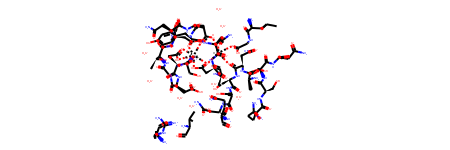

In [38]:
print(Num_of_proteins)
m=PDBMolecule(file_location)
m.molecule

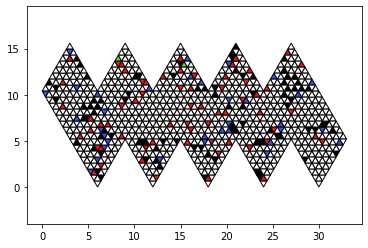

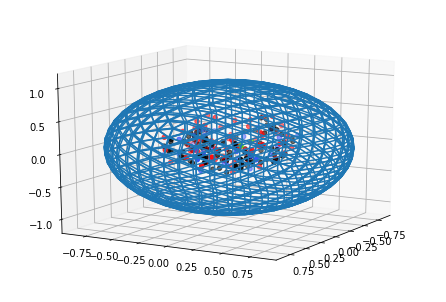

In [39]:

ico = Ico(m,3)
ico.draw2D()
ico.draw3D()

## THIS WORKS and makes the hdf5 files for the proteins

## THIS WORKS and makes the hdf5 files for the ligands

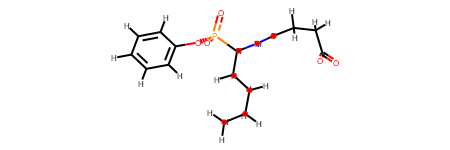

In [40]:
test_file='1a0q_ligand.mol2'
test_file_location=os.path.join(data_dir, '1a0q', test_file)
lig=Mol2Molecule(test_file_location)
lig.molecule

In [41]:
SMILES_array=['N[C@@H](C)C(=O)O','N[C@H](C)C(=O)O', 'C12C3C4C1C5C2C3C45','CCC(CC)O[C@@H]1C=C(C[C@@H]([C@H]1NC(=O)C)N)C(=O)OCC.OP(=O)(O)O']

# Tests

## Test of SMILES string list to hdf5 builder

In [42]:
SMILES_array=['N[C@@H](C)C(=O)O',
'N[C@H](C)C(=O)O',
'C12C3C4C1C5C2C3C45',
'CCC(CC)O[C@@H]1C=C(C[C@@H]([C@H]1NC(=O)C)N)C(=O)OCC.OP(=O)(O)O']

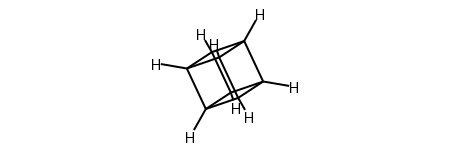

In [43]:
m=Molecule(SMILES_array[2])
m.molecule

Warning! Sanitize seems to muck up the structures, especially for protiens
Think very carefully about if you want to do this, maybe do some testing in deepchem?
Got to Molecule no.  0
1ps3
3d4z
3ejr
2qmj


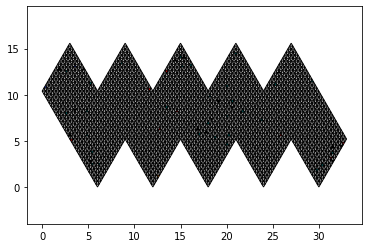

In [44]:
Create_Dataset_From_SMILES(DIVISION=4, 
                    save_dir = r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015', 
                    data_dir = r'C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015', 
                    out_filename = "SMILESTEST_div4.hdf5", 
                    ico_key_name = "icosahedron_level4",
                    do_Hdonors=True,
                    num_of_molecules_override=0,
                    NUM_MAPS_PER_MOLECULE=60,
                    sanitize=True,
                    SMILES_array=SMILES_array,
                    verbose=False)

### Test of pdb dataset builder 

Got to Molecule no.  0
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1ps3\1ps3_pocket.pdb
1ps3
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3d4z\3d4z_pocket.pdb
3d4z
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3ejr\3ejr_pocket.pdb
3ejr
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2qmj\2qmj_pocket.pdb
2qmj
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l4w\3l4w_pocket.pdb
3l4w
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l4u\3l4u_pocket.pdb
3l4u
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l7b\3l7b_pocket.pdb
3l7b
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3g2n\3g2n_pocket.pdb
3g2n
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3ebp\3ebp_pocket.pdb
3ebp
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2w66\2w66_pocket.pdb
2w66
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2wca\2wca_pocket.pdb
2wca
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2vvn\2vvn_pocket.pd

3uo4
Got to Molecule no.  100
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2wtv\2wtv_pocket.pdb
2wtv
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3myg\3myg_pocket.pdb
3myg
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3kgp\3kgp_pocket.pdb
3kgp
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1o5b\1o5b_pocket.pdb
1o5b
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1sqa\1sqa_pocket.pdb
1sqa
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3kwa\3kwa_pocket.pdb
3kwa
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2weg\2weg_pocket.pdb
2weg
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3dd0\3dd0_pocket.pdb
3dd0
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2xdl\2xdl_pocket.pdb
2xdl
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1yc1\1yc1_pocket.pdb
1yc1
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2yki\2yki_pocket.pdb
2yki
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1p1q\1p1q_po

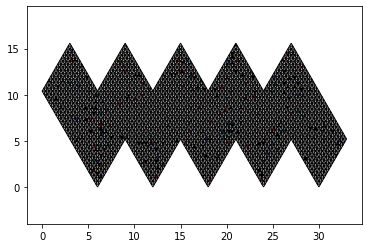

In [59]:


df_cluster = df_cluster_core
df_index = df_index_core
df_data = df_data_core

Create_PDBBind_Dataset(df_cluster = df_cluster_core, 
                df_index = df_index_core, 
                df_data = df_data_core, 
                DIVISION = 4, 
                save_dir = r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015', 
                data_dir = r'C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015', 
                out_filename = "2020_12_PDBBind_core_augmented_div4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'pdb',
                do_Hdonors = False,
                input_file_end_name='pocket',
                num_of_proteins_override= 0,
                NUM_MAPS_PER_MOLECULE=60,
                sanitize=False,
                SMILES_array=[],
                verbose=True)

Got to Molecule no.  0
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1ps3\1ps3_ligand.mol2
1ps3
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3d4z\3d4z_ligand.mol2
3d4z
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3ejr\3ejr_ligand.mol2
3ejr
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2qmj\2qmj_ligand.mol2
2qmj
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l4w\3l4w_ligand.mol2
3l4w
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l4u\3l4u_ligand.mol2
3l4u
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3l7b\3l7b_ligand.mol2
3l7b
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3g2n\3g2n_ligand.mol2
3g2n
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3ebp\3ebp_ligand.mol2
3ebp
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2w66\2w66_ligand.mol2
2w66
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2wca\2wca_ligand.mol2
2wca
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2vvn\2vv

2p4y
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3uo4\3uo4_ligand.mol2
3uo4
Got to Molecule no.  100
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2wtv\2wtv_ligand.mol2
2wtv
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3myg\3myg_ligand.mol2
3myg
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3kgp\3kgp_ligand.mol2
3kgp
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1o5b\1o5b_ligand.mol2
1o5b
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1sqa\1sqa_ligand.mol2
1sqa
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3kwa\3kwa_ligand.mol2
3kwa
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2weg\2weg_ligand.mol2
2weg
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\3dd0\3dd0_ligand.mol2
3dd0
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2xdl\2xdl_ligand.mol2
2xdl
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\1yc1\1yc1_ligand.mol2
1yc1
C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015\2

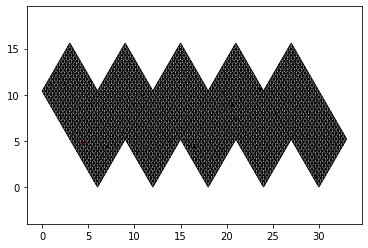

In [63]:


Create_PDBBind_Dataset(df_cluster = df_cluster_core, 
                df_index = df_index_core, 
                df_data = df_data_core, 
                DIVISION = 4, 
                save_dir = r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015', 
                data_dir = r'C:\Users\ella_\Nextcloud\science\Datasets\pdbbind\v2015', 
                out_filename = "2020_12_PDBBindLigand_core_augmented_div4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'mol2',
                do_Hdonors = True,
                input_file_end_name='ligand',
                num_of_proteins_override= 0,
                NUM_MAPS_PER_MOLECULE=60,
                sanitize=False,
                SMILES_array=[],
                verbose=True)

In [47]:
# there is no overlap!
[x 
 for x in df_index_core['PDB_code'] if x in df_index_refined['PDB_code']]

[]

In [58]:
'1f8b' in df_index_core['PDB_code']

False

In [48]:
#tests your h5 file

save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "PDBBindTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "PDBBindLigandTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "SMILESTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

[5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356 

C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()
C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
